In [273]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx

PLT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [242]:
# Grab IDs
file = open("citeseer.cites")
IDs = []
for line in file:
    from_node, to_node = line.split()
    if from_node not in IDs:
        IDs.append(from_node)
    if to_node not in IDs:
        IDs.append(to_node)
file.close()

# Compute adjacency matrix
adj_matrix = np.zeros((len(IDs),len(IDs)))
file = open("citeseer.cites")
for line in file:
    from_node, to_node = line.split()
    adj_matrix[IDs.index(from_node),IDs.index(to_node)] += 1
    adj_matrix[IDs.index(to_node),IDs.index(from_node)] += 1
file.close()

N_PAPERS = len(IDs)
N_FEATURES = 3703
# Grab contents
file = open("citeseer.content")

topics = ["Agents","AI","DB","IR","ML","HCI"]

X = np.zeros((N_PAPERS,N_FEATURES))
Y = np.zeros(N_PAPERS)

for line in file:
    split_line = line.split()
    
    ID = split_line[0]
    features = [int(n) for n in split_line[1:-1]]
    topic = split_line[-1]
    X[IDs.index(ID)] = np.array(features)/max(features)
    Y[IDs.index(ID)] = topics.index(topic)

N_CLASSES = len(topics)

# Transform to Pytorch Tensors
X_tensor = torch.Tensor(X).to(device)
Y_tensor = torch.Tensor(Y).long().to(device)

print("Number of papers: {}    Number of features: {}    Number of classes: {}".format(N_PAPERS,N_FEATURES,N_CLASSES))

Number of papers: 3327    Number of features: 3703    Number of classes: 6


<h2><center> Baseline with linear model on GCN

In [243]:
N_EPOCHS = 3000

input_size = N_FEATURES
hidden_size1 = 16
output_size = N_CLASSES

print("Architecture: {}".format([input_size,hidden_size1,output_size]))

linear_model = nn.Sequential( nn.Linear(input_size,hidden_size1),
                              nn.Tanh(),
                              nn.Linear(hidden_size1,output_size) ).to(device)

linear_model_optimizer = optim.Adam(linear_model.parameters(), lr=0.2)
linear_model_criterion = nn.CrossEntropyLoss()

losses = np.zeros(N_EPOCHS)
accuracies = np.zeros(N_EPOCHS)

for epoch in range(N_EPOCHS):
    print("Epoch [{}/{}]  ".format(epoch+1,N_EPOCHS),end="\r")
    linear_model.zero_grad()
    
    y_pred = linear_model(X_tensor)
    
    loss = linear_model_criterion(y_pred,Y_tensor)
    
    losses[epoch] = loss.item()

    loss.backward()
    linear_model_optimizer.step()
    
    pred = np.argmax(y_pred.cpu().detach().numpy(),axis=1)
    real = Y_tensor.cpu().detach().numpy()
    accuracies[epoch] = np.sum(pred==real)/len(y_pred)
    
    
    print("Epoch [{}/{}]  ".format(epoch+1,N_EPOCHS),"Loss: {:.4f}  Acc: {:.2%}    ".format(losses[epoch],accuracies[epoch]),end="\r")

Architecture: [3703, 16, 6]


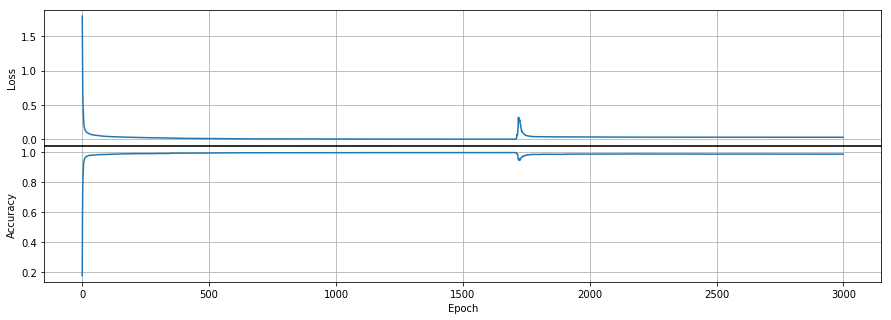

In [244]:
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(15,5))
fig.subplots_adjust(hspace=0.008)

ax1.plot(losses)
ax1.grid()
ax1.set_ylabel("Loss")

ax2.plot(accuracies)
ax2.grid()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")

plt.show()

<h2><center> GCN on Citeseer

In [267]:
class GraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size):
        super(GraphLayer,self).__init__()

        Ahat = adjacency_matrix + np.eye(len(adjacency_matrix))
        Dhat = np.diag(1/np.sqrt(np.sum(Ahat,axis=0)))
        
        self.M = torch.tensor(Dhat@Ahat@Dhat).float().to(device)
        self.W = nn.Parameter(torch.randn(input_size,output_size).float().to(device))
        
    def forward(self,X):
        return self.M @ X @ self.W  # X has dimensions (batch_size,node_index,data)
    
class SaveLayer(nn.Module):
    def __init__(self,save_to_this):
        super(SaveLayer, self).__init__()
        self.save_list = save_to_this
    def forward(self, x):
        self.save_list.append(x.cpu().detach().numpy())
        return x
    
def plot_embeddings(embeddings):
    
    marker = "P"
    point_size = 20
    marker_size = 200
    marker_alpha = 0.3
    window_size = 1.1
    
    h_plots = 4
    v_plots = 2

    community_colors = [None]*adj_matrix.shape[0]
    for node in range(len(classes)):
        community_colors[node] = PLT_COLORS[int(classes[node])]

    fig, axes = plt.subplots(v_plots,h_plots, sharex=True, sharey=True,figsize=(15,7.5))
    fig.subplots_adjust(wspace=0,hspace=0)
    for i, ax in enumerate(axes.flatten()):
        for l_node in labeled_indices:
            time = int(len(embeddings)*i/(h_plots*v_plots-1))
            if time == len(embeddings):
                time = len(embeddings) - 1
            ax.scatter(embeddings[time][l_node,0],embeddings[time][l_node,1],
                       color="k",s=marker_size,alpha=marker_alpha,marker=marker)

        for node1 in range(len(adj_matrix)):
            for node2 in range(node1,len(adj_matrix)):
                if node1 != node2:
                    if adj_matrix[node1,node2] != 0:
                        ax.plot([embeddings[time][node1,0],embeddings[time][node2,0]],
                                [embeddings[time][node1,1],embeddings[time][node2,1]],
                                color="k",zorder=0,alpha=0.05)

        ax.scatter(embeddings[time][:,0],embeddings[time][:,1],color=community_colors,s=point_size)
        ax.text(0,0.9,str(time if time != 499 else 500)+ " iterations",horizontalalignment='center')
        ax.set_xlim(-window_size,window_size)
        ax.set_ylim(-window_size,window_size)

In [278]:
input_size = N_FEATURES
hidden_size_1 = 16
embedding_size = 2
output_size = N_CLASSES

N_EPOCHS=1000

mask = torch.Tensor(np.random.binomial(1,0.036,len(Y))).byte()

labeled_nodes = []
for i,n in enumerate(mask.detach().float().numpy()):
    if n==1:
        labeled_nodes.append(i)


y_real = Y_tensor
y_selected_real = Y_tensor[mask]

embeddings = []

model = nn.Sequential(GraphLayer(adj_matrix, input_size, hidden_size_1),
                      nn.ReLU(),
                      GraphLayer(adj_matrix,hidden_size_1,embedding_size),
                      nn.Tanh(),
                      SaveLayer(embeddings),
                      GraphLayer(adj_matrix,embedding_size,output_size)).to(device)

print("Architecture: {}".format([input_size,hidden_size_1,output_size]))

inputs = X_tensor
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)

losses = np.zeros(N_EPOCHS)
total_losses = np.zeros(N_EPOCHS)
accuracies = np.zeros(N_EPOCHS)
total_accuracies = np.zeros(N_EPOCHS)


for epoch in range(N_EPOCHS):
    if((epoch+1)%50==0):
        print("Epoch [{}/{}] ".format(epoch+1,N_EPOCHS),end="\r")

    model.zero_grad()
    
    y_pred = model(inputs)

    y_selected_pred = y_pred[mask]

    loss = criterion(y_selected_pred,y_selected_real)

    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        loss2 = criterion(y_pred,y_real)
        losses[epoch] = loss.item()
        total_losses[epoch] = loss2.item()

        total_preds = np.argmax(y_pred.cpu().detach().numpy(),axis=1)
        total_reals = y_real.cpu().detach().numpy()

        preds = np.argmax(y_selected_pred.cpu().detach().numpy(),axis=1)
        reals = y_selected_real.cpu().detach().numpy()

        total_accuracies[epoch] = np.sum(total_preds == total_reals)/len(total_preds)
        accuracies[epoch] = np.sum(preds == reals)/len(preds)

    if((epoch+1)%50==0):
        print("Epoch [{}/{}]  ".format(epoch+1,N_EPOCHS),"T.Loss: {:.4f}  T.Acc: {:.2%}  S.Loss: {:.4f}  S.Acc: {:.2%}        ".format(total_losses[epoch],
                                                                                                                           total_accuracies[epoch],
                                                                                                                           losses[epoch],
                                                                                                                           accuracies[epoch]),end="\r")

Architecture: [3703, 16, 6]


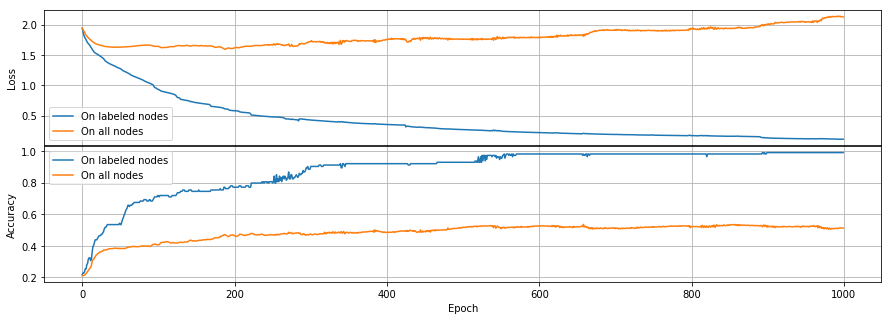

In [279]:
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(15,5))
fig.subplots_adjust(hspace=0.008)

ax1.plot(losses,label="On labeled nodes")
ax1.plot(total_losses,label="On all nodes")
ax1.legend()
ax1.grid()
ax1.set_ylabel("Loss")

ax2.plot(accuracies,label="On labeled nodes")
ax2.plot(total_accuracies,label="On all nodes")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("loss_accuracy_citeseer.pdf")
plt.show()

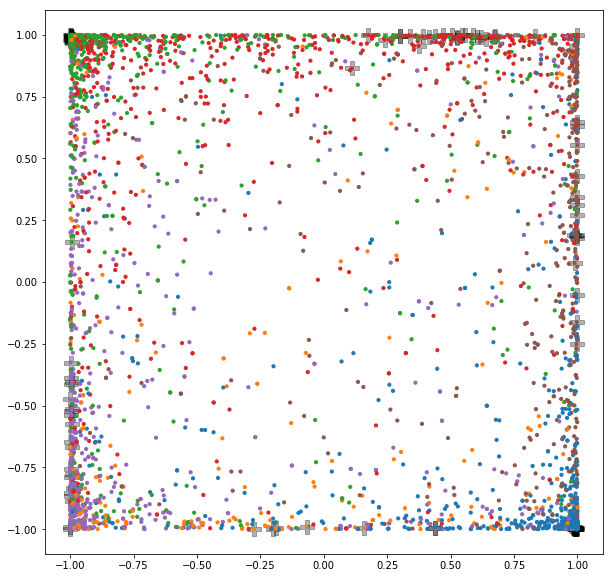

In [289]:
classes = Y
labeled_indices = labeled_nodes


 
marker = "P"
point_size = 10
marker_size = 200
marker_alpha = 0.3
window_size = 1.1

h_plots = 4
v_plots = 2

community_colors = [None]*adj_matrix.shape[0]
for node in range(len(classes)):
    community_colors[node] = PLT_COLORS[int(classes[node])]

plt.figure(figsize=(10,10))    

for l_node in labeled_indices:
    plt.scatter(embeddings[-1][l_node,0],embeddings[-1][l_node,1],
               color="k",s=marker_size,alpha=marker_alpha,marker=marker)

#for node1 in range(len(adj_matrix)):
#    for node2 in range(node1,len(adj_matrix)):
#        if node1 != node2:
#            if adj_matrix[node1,node2] != 0:
#                plt.plot([embeddings[-1][node1,0],embeddings[-1][node2,0]],
#                        [embeddings[-1][node1,1],embeddings[-1][node2,1]],
#                        color="k",zorder=0,alpha=0.05)

plt.scatter(embeddings[-1][:,0],embeddings[-1][:,1],color=community_colors,s=point_size)
plt.xlim(-window_size,window_size)
plt.ylim(-window_size,window_size)
plt.savefig("embeddings_citeseer.pdf")
plt.show()